# Analyser et visualiser une enquête sur les couleurs

Nous disposons d'un fichier csv, contenant les réponses données par des panélistes sur l'utilisation des couleurs en français. Nous souhaitons observer les couleurs mentionnées par les panélistes, et plus spécifiquement l'utilisation de "marron" et "brun". "marron" prend-t-il le pas sur "brun"?

Nous allons pour ce faire :
- partir du fichier csv contenant les réponses des personnes interrogées : "brun_marron.csv"
- utiliser des bibliothèques python (pandas, matplot, wordcloud).

Trouver les endroits où agir/modifier les paramètres dans ce document, chercher :

** CHOIX

<span style = "color: red"> !!! Document de travail</span> - travail en cours - à ne pas diffuser

In [1]:
# import des biblio python utiles
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Importer les données & premiers nettoyages

- importer le fichier csv

In [2]:
# import du fichier csv
csv_file="brun_marron.csv"
# créer l'objet "data", contenant l'ensemble des données
data = pd.read_csv(csv_file,delimiter='\t',keep_default_na=False)
data.head()
#print(len(data)) = 228 lignes

,CASE,SERIAL,REF,QUESTNNR,MODE,STARTED,PI06,PI01,PI02,PI03,...,LASTDATA,FINISHED,Q_VIEWER,LASTPAGE,MAXPAGE,MISSING,MISSREL,TIME_RSI,DEG_TIME,commentaires
0,52,,,base,interview,18/02/2021 08:26:32,1,3,1,4,...,18/02/2021 08:27:38,0,0,3,3,0,0,0.76,0,
1,54,,,base,interview,18/02/2021 08:29:26,1,3,1,4,...,18/02/2021 08:45:31,1,0,18,18,23,13,1.11,19,
2,55,,,base,interview,18/02/2021 08:30:42,1,4,2,1,...,18/02/2021 08:40:40,1,0,18,18,23,12,1.25,18,
3,61,,,base,interview,18/02/2021 08:57:24,1,4,2,1,...,18/02/2021 09:01:40,1,0,18,18,32,20,2.18,78,
4,63,,,base,interview,18/02/2021 08:59:29,1,4,1,1,...,18/02/2021 09:02:54,0,0,4,4,0,0,0.95,10,


- nettoyage préalable du fichier :

... un premier nettoyage formel qui ne modifie pas le contenu.

In [3]:
# modifier l'index par défaut, mettre comme index l'id des panelistes
data=data.set_index("CASE")
# mettre l'ensemble des noms en minuscule
data=data.apply(lambda x: x.astype(str).str.lower())
# remplacer les cases vides par NaN
data = data.replace(r'^\s*$', np.nan, regex=True)
                    
# nettoyer les valeurs de la colonne 'PI04_01'
# ... à la place d'une valeur vide je mets "français"
data['PI04_01'].fillna('français',inplace=True)

# enlever les espaces en fin de cellule (type string)                 
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

... créer de nouvelles colonnes et/ou valeurs pour aider à l'analyse

- insérer de nouvelles colonnes

la langue maternelle : français (oui/non)

In [4]:
# créer une colonne "français" : valeur oui/non 
# par défaut la colonne est créée avec comme valeur "oui"
data=data.assign(français="oui")
# si la colonne PI04_01 n'est pas "français" alors passage de la valeur à "non"
data.loc[data.PI04_01 != 'français','français']='non'

- la tranche d'âge

In [5]:
# quelle colonne ? PI01
dicTrancheAge={0:'nan',1:'moins de 12',2:'12-18',3:'19-30',4:'31-45',5:'46-60',6:'61-75',7:'plus de 75',8:'nan'}


- sélectionner l'ensemble de données sur lequel appliquer les traitements

** CHOIX

In [6]:
print("Nombre de lignes du tableau : " + str(data.shape[0]))

# ne garder que les panélistes ayant répondu en partie au questionnaire
# ... cad donné au moins une couleur (question 1)
# Enlever les panélistes n'ayant rien répondu, cad CO01x01 est vide (pas de première couleur)
data['CO01x01'].replace('', np.nan, inplace=True)
test=data.dropna(subset=['CO01x01'])
print("Nombre de panélistes retenus : " + str(test.shape[0]))

# uniquement les questionnaires complets
data_finished = data.loc[data['FINISHED']=='1']
#data.head()
print("Nombre de questionnaires complets : " + str(data_finished.shape[0]))

# pour travailler que sur les questionnaires complets
# décommenter la ligne suivante :
# data = data_finished


Nombre de lignes du tableau : 228
Nombre de panélistes retenus : 204
Nombre de questionnaires complets : 160


Vérifier que tout s'est bien passé, que notre objet data contient bien nos données. Regarder les premières lignes du tableau :

In [7]:
data.head()
# par défaut 5 ligne, si on en veut plus (par exemple 10):
# data.head(10)

,SERIAL,REF,QUESTNNR,MODE,STARTED,PI06,PI01,PI02,PI03,PI04_01,...,FINISHED,Q_VIEWER,LASTPAGE,MAXPAGE,MISSING,MISSREL,TIME_RSI,DEG_TIME,commentaires,français
CASE,,,,,,,,,,,,,,,,,,,,,
52,NaN,NaN,base,interview,18/02/2021 08:26:32,1,3,1,4,espagnol,...,0,0,3,3,0,0,0.76,0,NaN,non
54,NaN,NaN,base,interview,18/02/2021 08:29:26,1,3,1,4,espagnol,...,1,0,18,18,23,13,1.11,19,NaN,non
55,NaN,NaN,base,interview,18/02/2021 08:30:42,1,4,2,1,français,...,1,0,18,18,23,12,1.25,18,NaN,oui
61,NaN,NaN,base,interview,18/02/2021 08:57:24,1,4,2,1,français,...,1,0,18,18,32,20,2.18,78,NaN,oui
63,NaN,NaN,base,interview,18/02/2021 08:59:29,1,4,1,1,français,...,0,0,4,4,0,0,0.95,10,NaN,oui


- Visualiser le nom des colonnes :

In [8]:
data.columns

Index(['SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 'PI06', 'PI01', 'PI02',
       'PI03', 'PI04_01',
       ...
       'FINISHED', 'Q_VIEWER', 'LASTPAGE', 'MAXPAGE', 'MISSING', 'MISSREL',
       'TIME_RSI', 'DEG_TIME', 'commentaires', 'français'],
      dtype='object', length=174)

# Créer quelques fonctions utiles :

- <b>créer des ensembles de colonnes</b> :

Dans notre fichier, un ensemble de colonnes correspondant à un ensemble de réponses à une question donnée. Il nous faudra donc traiter des ensembles de colonnes. Afin de ne pas avoir à écrire des listes de noms de colonne, nous utilserons la fonction : lstCol

Exemple : récupérer les colonnes colonnes "CO01x01" à "CO01x25" (= énumération de couleurs).

Le nom des colonnes est ainsi constituée de :

. une chaîne de caractère ("CO01x")

. un chiffre (qui s'incrémente de col en col, de 1 à 25)

Il sera possible de lister l'ensemble des colonnes en appellant la fonction "lstCol" :

<b>lstCol(chaine de caract,nbre de colonne)</b> : lstCol("CO01x",26)


In [9]:
# fonction qui crée une liste de colonnes
# prend 2 arguments : chaine de caract et nbre de colonne
def lstCol (typeStr, nbCol):
    myLstCol=[]
    for i in range(1,nbCol):
        if i<10:
            nameCol=str(typeStr)+"0"+str(i)
        else:
            nameCol=str(typeStr)+str(i)
            
        myLstCol.append(str(nameCol))
    return myLstCol

- <b>constituer le lexique d'un ensemble de colonnes</b>

Créer une liste des termes contenus dans un ensemble de colonnes pour un dataframe donné.


In [10]:
def lstLexique(myCol,myDf):
    myDicLexique=dict()
    # valeurs absolue
    for col in myCol:   
        for key, value in myDf[col].value_counts().to_dict().items():
            #print(str(key)+"\t"+str(value))
            ## homogénéiser un minima le texte
            # = enlever les espaces en fin de chaine
            key=re.sub(r' $','',key)            
            ##compter
            if key in myDicLexique:
                myDicLexique[key]=value+myDicLexique[key]
            else:
                myDicLexique[key]=value
    
    myDfLexique = pd.DataFrame(list(myDicLexique.items()),columns=['lexique', 'number'])
    return myDfLexique

#lstLexique(myColColor,data)

- <b>Nombre d'occurrences : des valeurs absolues aux relatives</b> 

Depuis un dataframe donné compter le nombre d'occurrence relative du lexique.

In [11]:
# le dataframe donné en argument est constitué 
# d'une colonne lexique et d'une colonne number (nb occurrence du lexique)
def compteLexique(myDfLexique):
    
    #valeur relative
    myDfLexiqueRel = round((myDfLexique['number'] / myDfLexique['number'].sum()*100),2)
    #concatener les tableaux valeur absolue et valeur relative
    myDfLexique = pd.concat([myDfLexique, myDfLexiqueRel], axis=1)
    #nommer la 3eme colonne 'percent'
    myDfLexique.set_axis(['lexique','number','percent'],axis='columns', inplace=True)
    # par ordre alphébétique du lexique :
    # myDfLexique_sort = myDfLexique.sort_values(by = 'lexique', ascending = True)
    # par fréquence relative :
    myDfLexique_sort = myDfLexique.sort_values(by = 'percent', ascending = False)
    
    return (myDfLexique_sort)

- <b>Lister des panélistes selon un vocabulaire donné</b>

Soit une liste de termes :

    lister les panalistes ayant utilisés ces termes
    sur un ensemble de colonnes données
    
La fonction prend en argument :

    1/ une liste de termes
    
    2/ une liste de colonnes

En sortie :

    1 dictionnaire qui liste :
    
    - les panélistes qui ont un vocabulaire 'commun'
    
    - les panélistes qui ont un vocabulaire 'exclusif'
    

In [12]:
def findPanelistes(lstTermes, lstCol, myDf):
    dicTermPanel=dict()
    for term in lstTermes:
        dicTermPanel[term]=list()
        for col in lstCol:
            lg = len(myDf.index[myDf[col] == term].tolist())
            if lg > 0:
                for i in range(0, lg):
                    dicTermPanel[term].append(myDf.index[myDf[col] == term].tolist()[i])
    mesListes=list()
    #dicTermPanel={color1: [277, ...], color2: [66, ...], color3:[12, 14,...]}
    #return(dicTermPanel)
    
    dicComparePanel=dict()
    for nColor in range(0,len(myListTermes)):
        print(myListTermes[nColor])
        dicComparePanel[myListTermes[nColor]]=dict()
        
        lst_nColor = [i for i in range(len(myListTermes))]
        lst_nColor.remove(nColor)

        listCommune=list()
        listExclusif=list()
        
        for c in lst_nColor: 
            newlist=list(dicTermPanel[myListTermes[c]])
            
            if not listCommune :
                listCommune = list(dicTermPanel[myListTermes[c]])           
            else:             
                listCommune = list(set(listCommune) & set(newlist))
                
            if not listExclusif :
                listExclusif = list(dicTermPanel[myListTermes[c]])           
            else:
                listExclusif = list(set(listExclusif) | set(newlist))
        
        couleurActive=list(dicTermPanel[myListTermes[nColor]])
        
        dicComparePanel[myListTermes[nColor]]['commun']= list(set(couleurActive) & set(listCommune))
        dicComparePanel[myListTermes[nColor]]['exclusif']= list(set(couleurActive) - set(listCommune))
    
    #{'brun': {'commun': [384, 258,...], 'exclusif':[...]},
    # 'marron': {'commun': [384, 258,...], 'exclusif':[...]}
    return(dicTermPanel,dicComparePanel)

#len(findPanelistes(['marron','brun'], myColColor, data)[0]['marron'])
#print (dfColor)

- <b>Visualiser les résulats :</b>
    
    . graphique en barres

In [13]:
def vizu_bar(myDf):
    dep = pd.DataFrame(myDf,columns=["lexique","percent"])
    ax = dep.plot(x="lexique",kind = "bar", figsize=(18,6))
    ax.set_xlabel("lexique", fontsize=16)
    ax.set_title("Couleurs énoncées", fontsize=16)
    ax.legend().set_visible(False)  # on supprime la légende
    
    return ax

- visualisation en barres avec une variable supplémentaire

In [14]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      figsize=(10,8),
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 90)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe
    

. nuage de mots

In [15]:
def vizu_cloud_col(myDf2,colonne):
    #generate
    twoValues = pd.DataFrame(myDf2,columns=["lexique",colonne])
    tuples = [tuple(x) for x in twoValues.values]
    wordcloud=WordCloud(background_color="white").generate_from_frequencies(dict(tuples))
    # show
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return wordcloud

def vizu_cloud(myDf):
    #generate
    twoValues = pd.DataFrame(myDf,columns=["lexique","percent"])
    tuples = [tuple(x) for x in twoValues.values]

    wordcloud=WordCloud(background_color="white").generate_from_frequencies(dict(tuples))
    # show
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return wordcloud

- <b>quelques calculs nécessaires :</b>
    
   . sommer les valeurs d'une ligne :

In [16]:
# la fonction prend comme paramètres ...
# le nom du dataframe, le nom de la colonne à créer, le nom des colonnes
def sum_frame_by_column(frame, new_col_name, list_of_cols_to_sum):
    frame[new_col_name] = frame[list_of_cols_to_sum].astype(float).sum(axis=1)
    return(frame)

# ANALYSE DES DONNEES

## Quelles couleurs sont énoncées par le panel ?

Le questionnaire : "Écrivez ci-dessous les noms des couleurs principales en français"

Les réponses sont dans les colonnes nommées : CO01x01 ... CO01x25

A chaque nouvelle couleur citée par le panéliste une nouvelle colonne est créée.

NB. De nombreux panélistes arrêtent après avoir cité 12 / 13 couleurs.

- créer un tableau ne contenant que les colonnes où sont énoncées les couleurs

In [17]:
dataColors = data.reindex(columns = lstCol('CO01x',26))
#visualiser le résultat
dataColors.head()

,CO01x01,CO01x02,CO01x03,CO01x04,CO01x05,CO01x06,CO01x07,CO01x08,CO01x09,CO01x10,...,CO01x16,CO01x17,CO01x18,CO01x19,CO01x20,CO01x21,CO01x22,CO01x23,CO01x24,CO01x25
CASE,,,,,,,,,,,,,,,,,,,,,
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,rouge,jaune,bleu,vert,noir,blanc,gris,marron,rose,orange,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,bleu,rouge,vert,jaune,orange,violet,blanc,gris,noir,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,bleu,blanc,rouge,jaune,vert,rouge,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,rouge,jaune,bleu,vert,violet,rose,orange,blanc,noir,gris,...,turquoise,azur,émeraude,rubis,brun,olive,pistache,blond,fauve,doré


- créer une liste contenant le nom de ces colonnes :

In [18]:
myColColor = lstCol('CO01x',26)
#print(myColColor)      

- lister les couleurs et les compter

In [19]:
print(lstLexique(myColColor,data))

        lexique  number
0         rouge     203
1          bleu     196
2         jaune     190
3         blanc     157
4          noir     148
..          ...     ...
107       chair       1
108        maxi       1
109       ambre       1
110     mordoré       1
111  gris foncé       1

[112 rows x 2 columns]


... cette liste de couluers est à nettoyer.

1. Créer un fichier csv

In [20]:
lstLexique(myColColor,data).to_csv("lstCouleur.csv", sep = '\t', index = False)

2. Ouvrir le fichier csv créé (hors ce programme)

... Dédoubler la colonne "lexique",

... Renommer la colonne en "correction" (la laisser en position 2),

... Faire les corrections souhaitées dans cette colonne,

... Enregistrer le fichier csv "lstCouleur_nett.csv"

3. Importer le fichier csv, et travailler sur le lexique corrigé

In [21]:
# importer le csv de correction
propagCorrColor = pd.read_csv("lstCouleur_nett.csv",delimiter=',')

Modifier le dataframe 'data' :

Subsituer le mot de la colonne 'lexique' par le mot de la colonne 'correction'

In [22]:
propagCorrColor.set_index("lexique", drop=True, inplace=True)
# créer un dictionnaire de correction
dicCorrColor = propagCorrColor.to_dict()

for c in myColColor:    
    data[c]=data[c].map(dicCorrColor['correction'])

- Suite à la mise à jour de "data", recréer (=mettre à jour) le tableau des couleurs

In [23]:
dataColors = data.reindex(columns = lstCol('CO01x',26))
dataColors.head()

,CO01x01,CO01x02,CO01x03,CO01x04,CO01x05,CO01x06,CO01x07,CO01x08,CO01x09,CO01x10,...,CO01x16,CO01x17,CO01x18,CO01x19,CO01x20,CO01x21,CO01x22,CO01x23,CO01x24,CO01x25
CASE,,,,,,,,,,,,,,,,,,,,,
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,rouge,jaune,bleu,vert,noir,blanc,gris,marron,rose,orange,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,bleu,rouge,vert,jaune,orange,violet,blanc,gris,noir,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,bleu,blanc,rouge,jaune,vert,rouge,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,rouge,jaune,bleu,vert,violet,rose,orange,blanc,noir,gris,...,turquoise,azur,émeraude,rubis,brun,olive,pistache,blond,fauve,doré


- lister et compter le nombre d'occurrence de l'ensemble des couleurs ainsi nettoyées

In [24]:
print(lstLexique(myColColor,data))
#allColors=lstLexique(myColColor,data).lexique.tolist()
#print(allColors)

         lexique  number
0          rouge     205
1           bleu     200
2          blanc     159
3          jaune     192
4           noir     152
..           ...     ...
66       vermeil       1
67      pistache       1
68  gris (modif)       1
69          jade       1
70         chair       1

[71 rows x 2 columns]


Créer un tableau contenant la liste de couleurs, leur nombre d'occurrence ('number'), et le pourcentage de ces occurrences ('percent')

La fonction 'compteLexique' permet de calculer les pourcentages du lexique donné.

In [25]:
dfColor = compteLexique(lstLexique(myColColor,data))
print(dfColor)

       lexique  number  percent
0        rouge     205    10.40
1         bleu     200    10.15
3        jaune     192     9.74
5         vert     188     9.54
2        blanc     159     8.07
..         ...     ...      ...
51      ivoire       1     0.05
40      pastel       1     0.05
45      sienne       1     0.05
41  anthracite       1     0.05
70       chair       1     0.05

[71 rows x 3 columns]


AxesSubplot(0.125,0.125;0.775x0.755)


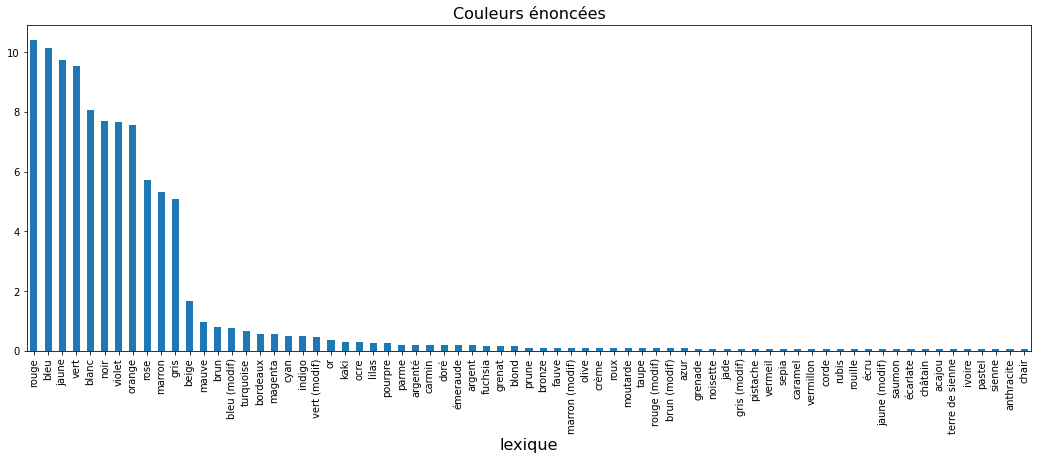

In [26]:
# visualisation de percent
print(vizu_bar(dfColor))

** CHOIX possible de :

    modifier les éléments présents dans le graph


AxesSubplot(0.125,0.125;0.775x0.755)


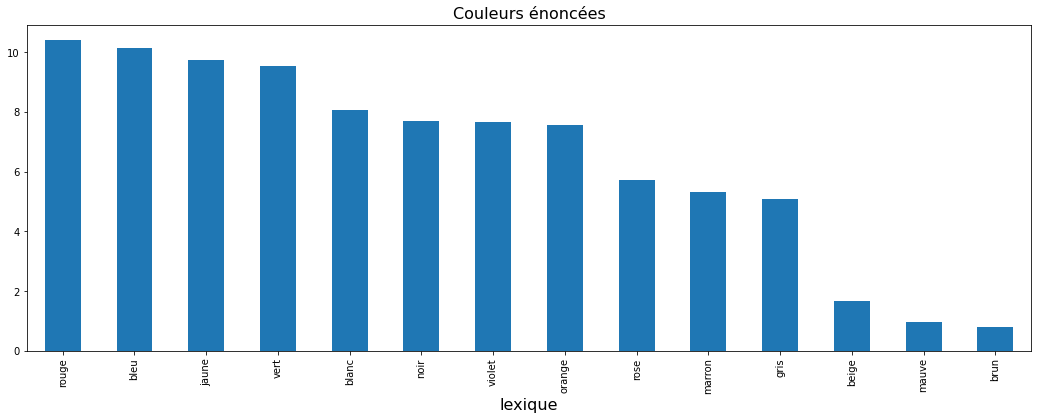

In [27]:
# 0.8 permet de garder "brun" et "marron"
df_maskColor=dfColor['percent']>=0.8
filtered_dfColor=dfColor[df_maskColor]
print(vizu_bar(filtered_dfColor))

- nuage de mots  de l'ensemble des couleurs énonées

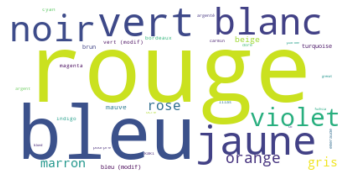

In [28]:
print(vizu_cloud_col(dfColor,'percent'))

## QUELLES COULEURS PAR QUELS PANELISTES ?

Considérons plusieurs couleurs, quels sont les pénalistes à avoir cité ou non ces couleurs ?

Il est donc possible de modifier les couleurs de l'objet "myListTermes" pour observer un autre binôme, trinôme.

Nos tests :

- comparer 'brun' et 'marron'

- comparer les couleurs primaires : 'bleu','rouge','jaune'

... TODO nb de couleur en moyenne par panéliste
voir les pénélistes "hors" norme -> peu ou très prolixe !

** CHOIX couleurs

In [29]:
# mettre les couleurs souhaitées entre guillemets séparées par une virgule

# par exemeple : les couleurs primaires:
# myListTermes=["bleu","rouge","jaune"]

# par exemple : pour notre étude... 
myListTermes=["brun","marron"]

In [30]:
for i, l in dfColor.iterrows():
    for color in myListTermes:
        if l["lexique"]==color:
            print(l)

lexique    marron
number        105
percent      5.33
Name: 10, dtype: object
lexique    brun
number       16
percent    0.81
Name: 16, dtype: object


<!--- Questionnaire : "Écrivez une liste de choses (êtres, objets,...) qu'on pourrait décrire proprement comme étant MARRON / BRUN:" --->

Quels sont les panélistes qui ont cité les couleurs sélectionnées ?

In [31]:
print("couleurs observées:")
for color, panel in findPanelistes(myListTermes,myColColor,data)[1].items():
    print("\nCouleur " + str(color))
    for k, p in panel.items():
        print("panéliste avec vocabulaire "+str(k)+" - soit "+ str(len(p)) +" panélistes")
        print(p)
        

couleurs observées:
brun
marron

Couleur brun
panéliste avec vocabulaire commun - soit 7 panélistes
[417, 496, 304, 277, 406, 474, 63]
panéliste avec vocabulaire exclusif - soit 9 panélistes
[133, 103, 77, 497, 466, 250, 219, 284, 413]

Couleur marron
panéliste avec vocabulaire commun - soit 7 panélistes
[417, 496, 304, 277, 406, 474, 63]
panéliste avec vocabulaire exclusif - soit 98 panélistes
[259, 278, 280, 282, 283, 287, 290, 292, 298, 306, 54, 310, 312, 313, 314, 315, 316, 319, 321, 323, 68, 325, 327, 72, 75, 333, 79, 80, 335, 84, 347, 95, 354, 99, 355, 357, 359, 104, 361, 106, 363, 367, 368, 370, 115, 116, 373, 374, 375, 380, 381, 382, 384, 132, 389, 390, 135, 136, 394, 140, 141, 400, 150, 408, 409, 410, 414, 415, 416, 422, 169, 426, 427, 428, 430, 175, 177, 178, 440, 186, 189, 197, 198, 203, 208, 464, 468, 215, 216, 218, 220, 475, 222, 487, 495, 242, 500, 504]


## Ordre d'énonciation des couleurs

Dans quel ordre un panéliste va-t-il énoncer les couleurs? En d'autres termes, quelle est la couleur qui lui vient en premier lieu à l'esprit ? 

- nombre d'occurrence de chacune des couleurs

In [32]:
# Selon la liste de termes choisis -> compter le nbr d'occ de chacun de ces termes
cptTotal=dict()
#listCommune = findPanelistes(myListTermes,myColColor)[0]

print("nb d'occ de chacune des couleurs :")
# x.number = val absolue / x.percent = val relative sur l'ens des couleurs nommées

for x in dfColor.itertuples():
    #print(x)
    for t in myListTermes:
        if x.lexique == t:
            print("Nn occ " + str(x.lexique) + "= " + str(x.number))
            cptTotal[x.lexique]=x.number

nb d'occ de chacune des couleurs :
Nn occ marron= 105
Nn occ brun= 16


- Dans quelle colonne du tableau la couleur est-elle mentionnée ?

La colonne 01 étant la prmeière remplie par le répondant, la 25 étant la dernière.
Le répondant peut ne donner arrêter son énumaration quand il le souhaite.

In [33]:
myDicOrdreColor = dict()

for colColor in myColColor:
    for term in myListTermes:
        # si le term est dans la ligne
        if data.index[data[colColor] == term].tolist():
            
            myRangColor=int(re.sub("^.+x0?","",colColor))
            myRangNbAbs=len(dataColors.index[data[colColor] == term].tolist())

            myRangNbRel = round(myRangNbAbs*100/cptTotal[term],2)
            myDuo=(myRangNbAbs,myRangNbRel)
        
            if term in myDicOrdreColor:
                if myRangColor in myDicOrdreColor[term]:
                    myDicOrdreColor[term][myRangColor].append(myDuo)
                else:
                    myDicOrdreColor[term][myRangColor]=myDuo
            else:
                myDicOrdreColor[term]=dict()
                myDicOrdreColor[term][myRangColor]=myDuo
                #myDicOrdreColor[term].append(myDuo)

# résultat = pour un terme donné :
# { term : { position/n Col: ( valAbs , valRel), ...}, ...}
print(myDicOrdreColor)
# Position 5 -> 4 ok
# Marron position 2 avec maj =1


{'marron': {2: (1, 0.95), 3: (1, 0.95), 4: (1, 0.95), 5: (4, 3.81), 6: (17, 16.19), 7: (25, 23.81), 8: (18, 17.14), 9: (14, 13.33), 10: (14, 13.33), 11: (3, 2.86), 12: (3, 2.86), 13: (2, 1.9), 14: (1, 0.95), 19: (1, 0.95)}, 'brun': {6: (2, 12.5), 7: (4, 25.0), 8: (2, 12.5), 9: (2, 12.5), 10: (1, 6.25), 14: (1, 6.25), 18: (2, 12.5), 20: (1, 6.25), 22: (1, 6.25)}}


Visualiser cet ordre d'apparition

** CHOIX possible de :

- visualiser les valeurs absolue (1) ou relatives (2)

- modifier l'apparence du graph

  couleur  pos2  pos3  pos4  pos5   pos6   pos7   pos8   pos9  pos10  pos11  \
0  marron  0.95  0.95  0.95  3.81  16.19  23.81  17.14  13.33  13.33   2.86   
1    brun  0.00  0.00  0.00  0.00  12.50  25.00  12.50  12.50   6.25   0.00   

   pos12  pos13  pos14  pos18  pos19  pos20  pos22  
0   2.86    1.9   0.95    0.0   0.95   0.00   0.00  
1   0.00    0.0   6.25   12.5   0.00   6.25   6.25  


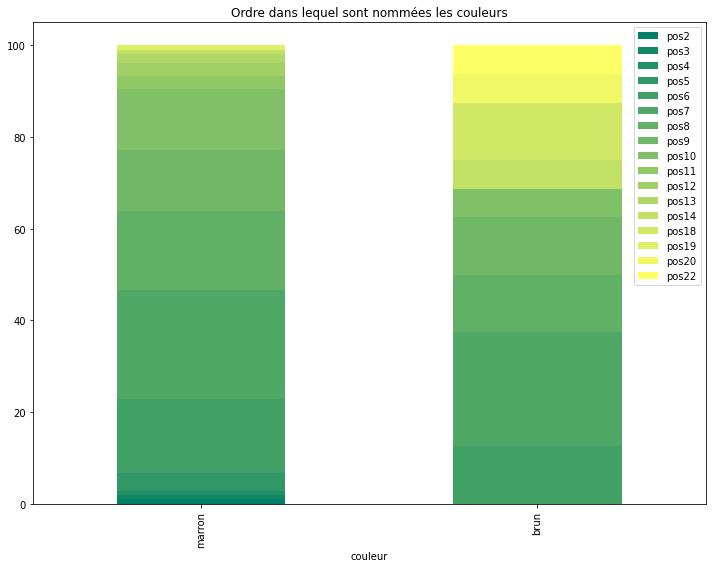

In [34]:
v = locals()
myColor = list()

# visulaser... les valeurs absolues : values[0] / les valeurs relatives : values[1]
for keyTerm in myDicOrdreColor:
    # dans l'ensemble des variables locales créer la variable : 
    # color_mean = list() - ou color reprend chacune des couleurs choisies
    v[str(keyTerm)+str("_mean")] = [keyTerm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    # isoler les variables ainsi créées
    myColor.append(eval(str(keyTerm)+str("_mean")))
    
    for pos, values in myDicOrdreColor[keyTerm].items():
        # (1) VALEURS ABSOLUES
        # eval(keyTerm+str("_mean"))[pos] = values[0]
        # TO ici j'en ai aussi 95!!!
        # (2) VALEURS RELATIVES
        eval(keyTerm+str("_mean"))[pos] = values[1]
        
columnsName=list()
columnsName.append('couleur')
for i in range(1,26):
    name='pos'+str(i)
    columnsName.append(name)

# create data
#print(myColor)
df = pd.DataFrame(myColor,columns=columnsName)
# Ne garder que les positions non nulles pour l'ens des couleurs (=> enlever si chacune est à 0)
df_NotNul=df.loc[:, (df != 0).any(axis=0)]
print(df_NotNul)

# APPARENCE GRAPHE
# dégradé de couleurs modifiable
# http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/Show_colormaps
# (3) colormap='Blues','RdBu','winter'
df_NotNul.plot(x='couleur', kind='bar', stacked=True, colormap='summer', figsize=(10,8),
        title='Ordre dans lequel sont nommées les couleurs')

plt.tight_layout()
plt.show()


# OBJETS MARRON

- Créer un sous-dataframe des colonnes concernées (colonnes LI01x01 à LI01x15)

In [35]:
myColObjMarron = lstCol('LI01x',16)

- lister et compter les objets marron :

In [36]:
print(lstLexique(myColObjMarron,data))

           lexique  number
0             bois      85
1            terre      65
2           marron      27
3             yeux      35
4        châtaigne      22
..             ...     ...
290  pomme pourrie       1
291         bottes       1
292        gateaux       1
293         plante       1
294     hippocampe       1

[295 rows x 2 columns]


Créer un fichier csv pour nettoyer le lexique

In [37]:
lstLexique(myColObjMarron,data).to_csv("objMarron.csv", sep = '\t', index = False)

In [38]:
# importer le csv de correction
propagObjMarron = pd.read_csv("objMarron_nett.csv",delimiter=',')

propagObjMarron.set_index("lexique", drop=True, inplace=True)
# créer un dictionnaire de correction
dicCorrObjMarron = propagObjMarron.to_dict()

for c in myColObjMarron:    
    data[c]=data[c].map(dicCorrObjMarron['correction'])

In [39]:
dfObjMarron = compteLexique(lstLexique(myColObjMarron,data))
print(dfObjMarron)

             lexique  number  percent
0               bois     100    10.19
3              terre      78     7.95
5           chocolat      67     6.83
1             marron      51     5.20
7         excréments      49     4.99
..               ...     ...      ...
87        chaussette       1     0.10
86   pâte_à_tartiner       1     0.10
85            amande       1     0.10
83             objet       1     0.10
156       hippocampe       1     0.10

[157 rows x 3 columns]


- visualisé ce qui est supérieur ou égal à 1%

** CHOIX :

- modifier le mask (modifier le pourcentage)

- visualiser l'ensemble des objets 

AxesSubplot(0.125,0.125;0.775x0.755)


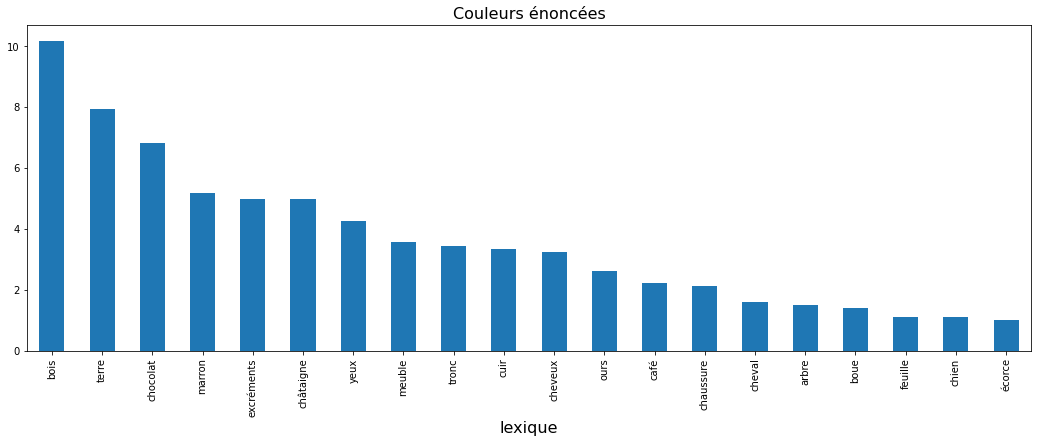

In [40]:
df_mask=dfObjMarron['percent']>=1
filtered_dfObjMarron=dfObjMarron[df_mask]
print(vizu_bar(filtered_dfObjMarron))
# décommenter ligne ci-dessous, pour voir l'ensemble des objets
#print(vizu_bar(dfObjMarron))

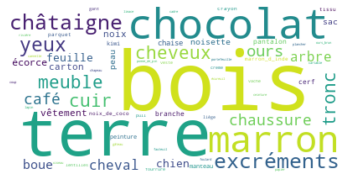

In [41]:
print(vizu_cloud_col(dfObjMarron,'percent'))

# OBJETS BRUN

- Créer un sous-dataframe des colonnes concernées (colonnes LI02x01 à LI02x15)

In [42]:
myColObjBrun = lstCol('LI02x',16)

- regarder le lexique

In [43]:
print(lstLexique(myColObjBrun,data))

                       lexique  number
0                      cheveux     117
1                         ours      57
2                       cheveu       5
3                         bois      15
4                         yeux      33
..                         ...     ...
188                      lampe       1
189              peau meurtrie       1
190                 devantures       1
191                      vison       1
192  souches d'arbres pourries       1

[193 rows x 2 columns]


In [44]:
lstLexique(myColObjBrun,data).to_csv("objBrun.csv", sep = '\t', index = False)

- nettoyer, calculer...

In [45]:
# importer le csv de correction
propagObjBrun = pd.read_csv("objBrun_nett.csv",delimiter=',')

propagObjBrun.set_index("lexique", drop=True, inplace=True)
# créer un dictionnaire de correction
dicCorrObjBrun = propagObjBrun.to_dict()

for c in myColObjBrun:    
    data[c]=data[c].map(dicCorrObjBrun['correction'])
    
dfObjBrun = compteLexique(lstLexique(myColObjBrun,data))
print(dfObjBrun)

          lexique  number  percent
0         cheveux     136    25.52
1            ours      65    12.20
3            yeux      34     6.38
22           peau      23     4.32
2            bois      21     3.94
..            ...     ...      ...
70           rhum       1     0.19
72       aliments       1     0.19
44           pull       1     0.19
75   montbéliarde       1     0.19
105         lampe       1     0.19

[106 rows x 3 columns]


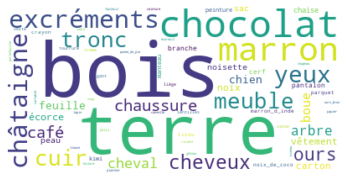

In [46]:
print(vizu_cloud_col(dfObjMarron,'percent'))

- visualisé ce qui est supérieur ou égal à 1%

** CHOIX :

- modifier le mask (modifier le pourcentage)

- visualiser l'ensemble des objets 

AxesSubplot(0.125,0.125;0.775x0.755)


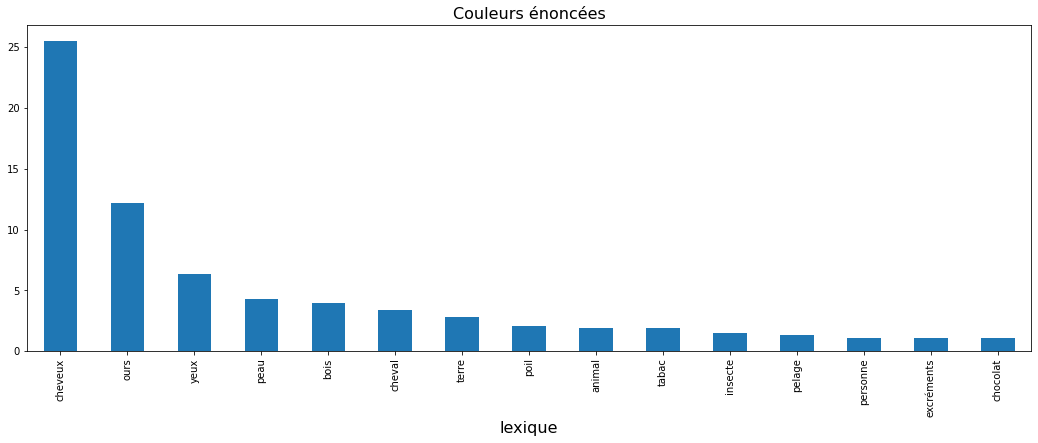

In [47]:
df_mask=dfObjBrun['percent']>=1
filtered_dfObjBrun=dfObjBrun[df_mask]

print(vizu_bar(filtered_dfObjBrun))
#print(vizu_bar(dfObjBrun))

## objets BRUN et/ou MARRON

Il est plus parlant et aisé d'observer l'ensemble de ces objets avec la variable couleur : brun ou marron. 

In [48]:
# créer un df objet/couleur/compte
new_Brun=dfObjBrun.assign(color='brun')
del new_Brun['percent']
new_Marron=dfObjMarron.assign(color='marron')
del new_Marron['percent']

frames = [new_Marron, new_Brun]
df_BrunMarron = pd.concat(frames).sort_values(by = ['lexique', 'color'])

#df_BrunMarron.set_index(['lexique','color'], inplace = True)
print(df_BrunMarron)

      lexique  number   color
69      algue       1    brun
72   aliments       1    brun
85     amande       1  marron
47   andalous       1    brun
10     animal      10    brun
..        ...     ...     ...
13     écorce      10  marron
15   écureuil       3    brun
56   écureuil       2  marron
141   étagère       1  marron
149      étui       1  marron

[263 rows x 3 columns]


In [49]:
# nb d'occ de chaque objet
objets = df_BrunMarron.groupby(['lexique']).sum()
print(objets)

          number
lexique         
algue          1
aliments       1
amande         1
andalous       1
animal        11
...          ...
yeux          76
écorce        14
écureuil       5
étagère        1
étui           1

[211 rows x 1 columns]


In [50]:
# table de contingence
df_objMarronBrun = df_BrunMarron.pivot(index = 'lexique', columns = 'color', values = 'number')
#remmplacer les valueurs NaN par 0
df_objMarronBrun=df_objMarronBrun.fillna(0)

df_objMarronBrun['lexique'] = df_objMarronBrun.index
print(df_objMarronBrun)

color     brun  marron   lexique
lexique                         
algue      1.0     0.0     algue
aliments   1.0     0.0  aliments
amande     0.0     1.0    amande
andalous   1.0     0.0  andalous
animal    10.0     1.0    animal
...        ...     ...       ...
yeux      34.0    42.0      yeux
écorce     4.0    10.0    écorce
écureuil   3.0     2.0  écureuil
étagère    0.0     1.0   étagère
étui       0.0     1.0      étui

[211 rows x 3 columns]


color     brun  marron   lexique  somme
lexique                                
algue      1.0     0.0     algue    1.0
aliments   1.0     0.0  aliments    1.0
amande     0.0     1.0    amande    1.0
andalous   1.0     0.0  andalous    1.0
animal    10.0     1.0    animal   11.0
...        ...     ...       ...    ...
yeux      34.0    42.0      yeux   76.0
écorce     4.0    10.0    écorce   14.0
écureuil   3.0     2.0  écureuil    5.0
étagère    0.0     1.0   étagère    1.0
étui       0.0     1.0      étui    1.0

[211 rows x 4 columns]

Visualistion marron et brun :
montre bien les termes importants pour ces 2 couleurs...


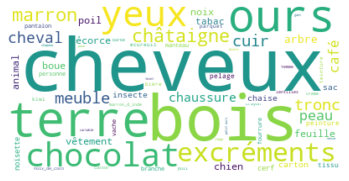


... et leur répartition! :

Visualistion marron :


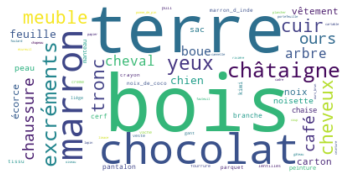


Visualistion brun :


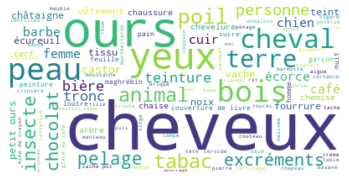

In [51]:
sums=sum_frame_by_column(df_objMarronBrun, 'somme', ['brun','marron'])
print(sums)
#print(sums.columns.tolist())

print("\nVisualistion marron et brun :")
print("montre bien les termes importants pour ces 2 couleurs...")
vizu_cloud_col(sums,'somme')

print("\n... et leur répartition! :")

print("\nVisualistion marron :")
vizu_cloud_col(sums,'marron')

print("\nVisualistion brun :")
vizu_cloud_col(sums,'brun')

- Selon le classement <b>Forbes</b>

In [52]:
# mettre sous format excel la sortie
df_BrunMarron.to_csv("Objets_BrunMarron.csv", sep = '\t', index = False)
# associer à chacun des termes 1 cat Forbes, réimporter le fichier
# créer l'objet "df_forbes", contenant l'association objet / cat forbes
df_forbes = pd.read_csv("Objets_BrunMarron_Forbes.csv",delimiter='\t')
df_forbes.head()

,lexique,number,color,forbes
0,adorable,1,brun,miscellaneous
1,aimable,1,brun,miscellaneous
2,algue,1,brun,food
3,aliments,1,brun,food
4,amande,1,marron,food


In [53]:
# todo visualiser Forbes
# 1. additionner les occ pour un même forbes
# 2. croiser les 3 variables lexique / color / forbes

## ACCEPTABILITE DE QUELQUES PHRASES ...

Questionnaire : "Est-ce que ces phrases sont acceptables dans la langue française courante ?"
    
A101_01 -> A101_05
...
A105_01 -> A105_05

Réponse -1 (pas acceptable) à 3 (tout à fait acceptable)

## ACCEPTABILITE DE DERIVES

DE01_01 -> DE01_10

Questionnaire : "Quels termes sont acceptables dans la langue française courante ?"


In [54]:
# import du fichier csv
csv_col="derives.csv"
# créer l'objet "data", contenant l'ensemble des données
derive = pd.read_csv(csv_col)
myNamesColonnes=derive['dérivé'].tolist()
print(myNamesColonnes)

['violacé', 'marronnasse', 'verdelet', 'marronâtre', 'rougeâtre', 'brunâtre', 'griselet', 'mauvasse', 'olivacé', 'bleuâtre']


Ces différents dévrivés sont ressentis comme plus ou moins acceptables par les locuteurs.

- les différentes langues parlée par les panélistes

In [55]:
print("\nliste des diverses langues :")
print(data['PI04_01'].unique())

print("\nNombre total de panélistes :")
print(data['PI04_01'].value_counts().sum())

print("\nNombre total de panélistes par langue :")
print(data['PI04_01'].value_counts())



liste des diverses langues :
['espagnol' 'français' 'le chinois' 'anglais' "l'arabe"
 'néerlandais (flamand)' 'mandarin' 'roumain' 'croate' 'allemand' 'arabe'
 'arabe algérien' 'suédois' 'italien' "l'algérien" "l'allemand" 'hebreu']

Nombre total de panélistes :
228

Nombre total de panélistes par langue :
français                 196
allemand                   5
arabe                      5
espagnol                   5
italien                    3
l'arabe                    2
anglais                    2
néerlandais (flamand)      1
hebreu                     1
l'allemand                 1
le chinois                 1
arabe algérien             1
roumain                    1
suédois                    1
mandarin                   1
l'algérien                 1
croate                     1
Name: PI04_01, dtype: int64


Est-ce que l'acceptabilité varie selon que le panéliste est de langue maternelle française ?

** CHOIX :
    
    - visualiser l'acceptabilité des dérivés pour l'ensemble des panalistes (1)
    
    - visualiser l'acceptabilité des dérivés pour les natifs français (2) / non natifs français (3)
    

In [56]:
myColDerives=lstCol('DE01_',11)
#print(myColDerives)

df_maskFrancais=data['français']=='oui'
filtered_dfFrancais=data[df_maskFrancais]

df_maskNoFrancais=data['français']=='non'
filtered_dfNoFrancais=data[df_maskNoFrancais]

#df_maskAge=data['PI01']=='2'
#filtered_dfAge=data[df_maskAge]

# Créer un sous tableau ne contenant que ces colonnes
# (1) avec l'ensemble des panélistes !
dataDerives = data.loc[:,myColDerives]
# (2) en ne gardant que les "français"
#dataDerives = filtered_dfFrancais.loc[:,myColDerives]
# (3) en ne gardant que les "français"
#dataDerives = filtered_dfNoFrancais.loc[:,myColDerives]

#dataDerives = filtered_dfAge.loc[:,myColDerives]

print("Nombre de panélistes concernés : " + str(len(dataDerives)))

#print(df.isnull().sum(axis=1))
index_with_nan = dataDerives.index[dataDerives.isnull().any(axis=1)]
dataDerives.drop(index_with_nan,0, inplace=True)
#mettre les bons titres :
dataDerives.columns = myNamesColonnes


Nombre de panélistes concernés : 228


In [57]:
# enlever les lignes où tout est "Na"
dataDerives.dropna(how = 'all',inplace = True)

# calculer les réponses données par couleur -> list de dico : 
myCptDerive=[dataDerives[c].value_counts().to_dict() for c in list(myNamesColonnes)]
#print(myCptDerive)

# mettre le résultat en dataframe
myDfAcceptabilite = pd.DataFrame.from_dict(myCptDerive)
myDfAcceptabilite = myDfAcceptabilite.fillna(0)

# enlever la colonne 0.0 
# ??? que signifiait cette valeur -> ? non répondu
try:
    del myDfAcceptabilite['0']
    # renommer les colonnes
    myDfAcceptabilite.rename(columns = {'1': 'très_acceptable', '2': 'passable', '3':'peu_acceptable','-1':'nsp'},inplace = True) 
except:
    myDfAcceptabilite.rename(columns = {'1': 'très_acceptable', '2': 'passable', '3':'peu_acceptable','-1':'nsp'},inplace = True) 

    # inverser ligne et colonne
myDfAcceptabilite=myDfAcceptabilite.transpose()
# renommer les colonnes
myDfAcceptabilite.columns = myNamesColonnes
# inverser ligne et colonne
myDfAcceptabilite=myDfAcceptabilite.transpose()
#print(myDfAcceptabilite)

In [58]:
# calculer la somme de chaque ligne
myDfAcceptabilite=sum_frame_by_column(myDfAcceptabilite, 'somme', ['peu_acceptable','très_acceptable','passable','nsp'])

# calcul des valeurs relatives, arrondi à 2 chiffres après la virgule
myDfAcceptabilite = round(myDfAcceptabilite.drop("somme", axis=1).divide(myDfAcceptabilite.somme, axis=0),2)
#myDfAcceptabilite.index("couleur")
#myDfAcceptabilite.rename_axis("color", axis='index', inplace=True)
myDfAcceptabilite = myDfAcceptabilite.rename_axis('color').reset_index()
#myDfAcceptabilite['color']=myDfAcceptabilite.index
print(myDfAcceptabilite)

         color  très_acceptable  passable   nsp  peu_acceptable
0      violacé             0.59      0.30  0.06            0.05
1  marronnasse             0.20      0.26  0.11            0.42
2     verdelet             0.03      0.27  0.26            0.44
3   marronâtre             0.21      0.38  0.08            0.34
4    rougeâtre             0.89      0.08  0.03            0.01
5     brunâtre             0.72      0.19  0.05            0.04
6     griselet             0.05      0.21  0.30            0.44
7     mauvasse             0.01      0.13  0.16            0.71
8      olivacé             0.09      0.33  0.17            0.41
9     bleuâtre             0.65      0.22  0.07            0.06


  acceptabilité  très_acceptable  passable  peu_acceptable   nsp
0       violacé             0.59      0.30            0.06  0.05
1   marronnasse             0.20      0.26            0.11  0.42
2      verdelet             0.03      0.27            0.26  0.44
3    marronâtre             0.21      0.38            0.08  0.34
4     rougeâtre             0.89      0.08            0.03  0.01
5      brunâtre             0.72      0.19            0.05  0.04
6      griselet             0.05      0.21            0.30  0.44
7      mauvasse             0.01      0.13            0.16  0.71
8       olivacé             0.09      0.33            0.17  0.41
9      bleuâtre             0.65      0.22            0.07  0.06


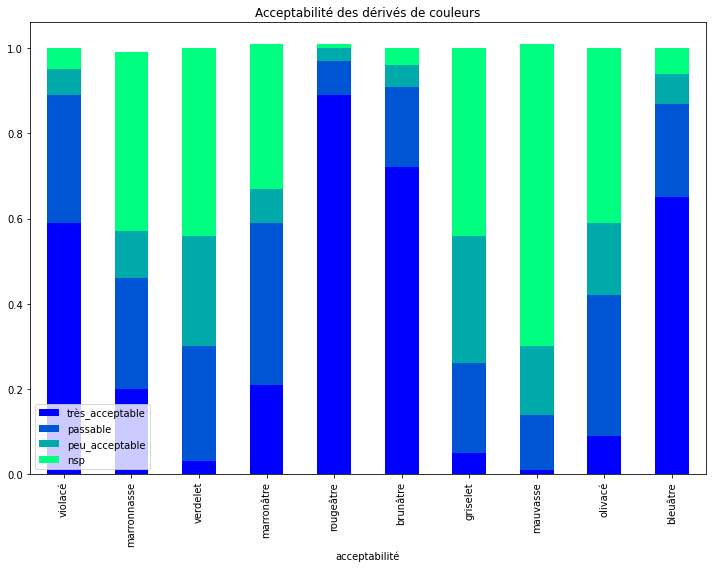

In [59]:
myLstAcceptabilite = [[i for i in row] for row in myDfAcceptabilite.itertuples()]
#myLstAcceptabilite = [[i for i in row] for row in myDfAcceptabilite.tolist()]
#print(myDfAcceptabilite)
myLstAcceptabilite = myDfAcceptabilite.values.tolist()
#print(myLstAcceptabilite)

df = pd.DataFrame(myLstAcceptabilite,columns=['acceptabilité','très_acceptable','passable','peu_acceptable','nsp'])
# Ne garder que les positions non nulles pour l'ens des couleurs (=> enlever si chacune est à 0)
df_NotNul=df.loc[:, (df != 0).any(axis=0)]
# view data
print(df_NotNul)

# APPARENCE GRAPHE
# dégradé de couleurs modifiable
# http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/Show_colormaps
# colormap='Blues','RdBu','winter'
df_NotNul.plot(x='acceptabilité', kind='bar', stacked=True, colormap='winter', figsize=(10,8),
    title='Acceptabilité des dérivés de couleurs')

# ne pas empiler les barres
# df_NotNul.plot(x='acceptabilité', kind='bar', colormap='winter', figsize=(10,8),title='Acceptabilité des dérivés de couleurs')
plt.tight_layout()
plt.show()

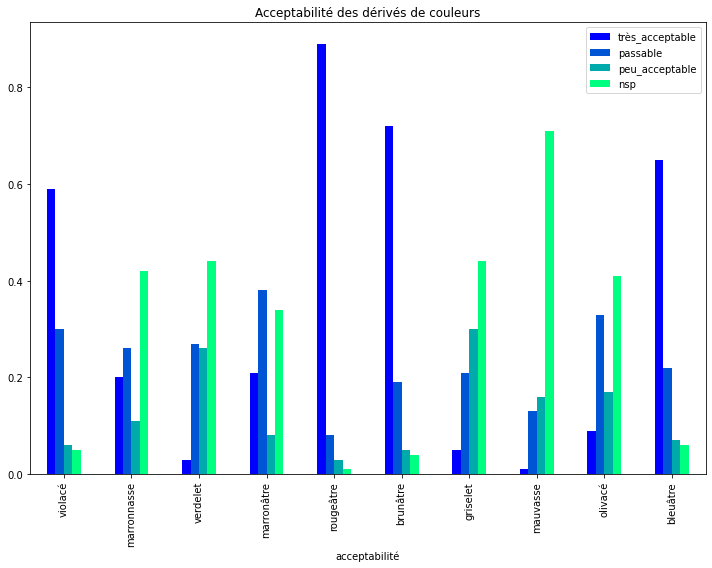

In [60]:
# ne pas emplier les barres...
df_NotNul.plot(x='acceptabilité', kind='bar', colormap='winter', figsize=(10,8),title='Acceptabilité des dérivés de couleurs')
plt.tight_layout()
plt.show()

- Insérons une variable supplémentaire...

L'acceptabilité est-elle lié à la langue, à l'âge ....

(!!! travail en cours....
TODO valeur relatives + faire une fonction pour permettre la variation des variables / ne pas dupliquer)

In [79]:
# ajouter le critère 'langue'
test=[data.groupby('français')[c].value_counts().to_dict() for c in list(myColDerives)]
#print(test)
myDfTest = pd.DataFrame.from_dict(test)
myDfTest = myDfTest.fillna(0)
#print(myDfTest)
#'1': 93, '2': 47, '-1': 9, '3': 8, '0': 1

print("nb de noms de couleurs (dérivés):"+str(len(test)))

myDicTemp=dict()

# 1 dico par color (dérivés de couleurs)
for color in range(0,len(test)):
    #print(color)
    if color not in myDicTemp:
        myDicTemp[color]=dict()
        # la clef du dico = tuple - ici k, avec k = var, accept // tel que : ('non', '2')
        for k, value in test[color].items():
            if k[1] not in myDicTemp[color]:
                 myDicTemp[color][k[1]]=[0,0]
            if k[0]=='oui':
                myDicTemp[color][k[1]][0]=value
            elif k[0]=='non':
                myDicTemp[color][k[1]][1]=value

# valeurs absolues
#print(myDicTemp)

#['peu_acceptable','très_acceptable','passable','nsp'])
# myVar=('-1','0','1','2','3')

# créer les varibles utiles à la visualisation barre multi cluster
# la liste de couleurs (dérivés)
index = list()
# les données d'acceptabilité - un frame par variable
framePeuAccept=list()
framePassable=list()
frameTresAccept=list()
frameNsp=list()
# la variable supplémantaire
columns=["fr", "noFr"]

#'1': 'très_acceptable', '2': 'passable', '3':'peu_acceptable','-1':'nsp'
for color, dicAccept in myDicTemp.items():
    #print (myNamesColonnes[color])
    index.append(myNamesColonnes[color])
    for accept, tup in dicAccept.items():
        if accept == '3':
            framePeuAccept.append(tup)
        elif accept == '2':
            framePassable.append(tup)
        elif accept == '1':
            frameTresAccept.append(tup)
        elif accept == '-1':
            frameNsp.append(tup)
    


nb de noms de couleurs (dérivés):10


<AxesSubplot:title={'center':'multiple stacked bar plot'}>

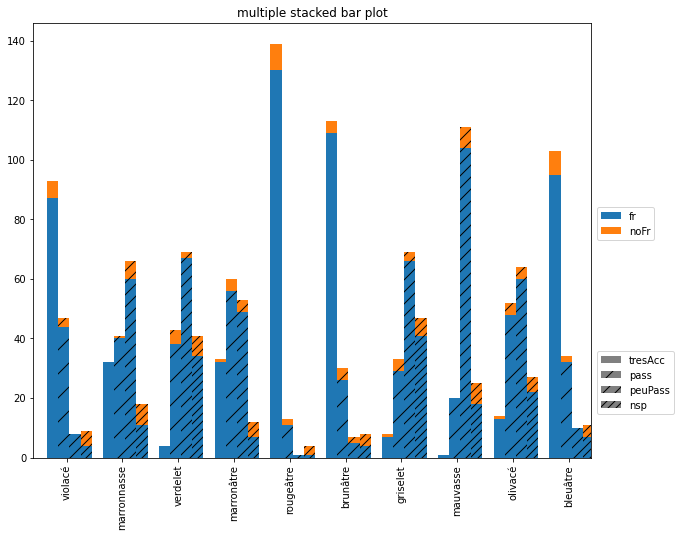

In [80]:
# create fake dataframes
df_tresAcc = pd.DataFrame(frameTresAccept,
                   index=index,
                   columns=columns)

df_pass = pd.DataFrame(framePassable,
                   index=index,
                   columns=columns)

df_peuPass = pd.DataFrame(framePeuAccept,
                   index=index,
                   columns=columns)

df_nsp = pd.DataFrame(frameNsp,
                   index=index,
                   columns=columns)
# Then, just call :
plot_clustered_stacked([df_tresAcc, df_pass, df_peuPass,df_nsp],["tresAcc", "pass", "peuPass","nsp"])

In [89]:
# quelle colonne ? PI01
#dicTrancheAge={0:'nan',1:'moins de 12',2:'12-18',3:'19-30',4:'31-45',5:'46-60',6:'61-75',7:'plus de 75',8:'nan'}
# ajouter le critère 'langue'
test=[data.groupby('PI01')[c].value_counts().to_dict() for c in list(myColDerives)]
#print(test)
myDfTest = pd.DataFrame.from_dict(test)
myDfTest = myDfTest.fillna(0)
#print(myDfTest)
#'1': 93, '2': 47, '-1': 9, '3': 8, '0': 1

print("nb de noms de couleurs (dérivés):"+str(len(test)))

myDicTemp=dict()

# 1 dico par color (dérivés de couleurs)
for color in range(0,len(test)):
    #print(color)
    if color not in myDicTemp:
        myDicTemp[color]=dict()
        # la clef du dico = tuple - ici k, avec k = var, accept // tel que : ('non', '2')
        for k, value in test[color].items():
            if k[1] not in myDicTemp[color]:
                 myDicTemp[color][k[1]]=[0,0,0,0,0,0,0,0,0]
            #print(k[0])
            myDicTemp[color][k[1]][int(k[0])-1]=value

# valeurs absolues
#print(myDicTemp)

# créer les varibles utiles à la visualisation barre multi cluster
# la liste de couleurs (dérivés)
index = list()
# les données d'acceptabilité - un frame par variable
framePeuAccept=list()
framePassable=list()
frameTresAccept=list()
frameNsp=list()
# la variable supplémantaire
#columns=["tr1", "tr2","tr3", "tr4","tr5", "tr6","tr7", "tr8","tr9"]
#dicTrancheAge={0:'nan',1:'moins de 12',2:'12-18',3:'19-30',4:'31-45',5:'46-60',6:'61-75',7:'plus de 75',8:'nan'}
columns=['nan','moins de 12','12-18','19-30','31-45','46-60','61-75','plus de 75','nan']

#'1': 'très_acceptable', '2': 'passable', '3':'peu_acceptable','-1':'nsp'
for color, dicAccept in myDicTemp.items():
    #print (myNamesColonnes[color])
    index.append(myNamesColonnes[color])
    for accept, tup in dicAccept.items():
        if accept == '3':
            framePeuAccept.append(tup)
        elif accept == '2':
            framePassable.append(tup)
        elif accept == '1':
            frameTresAccept.append(tup)
        elif accept == '-1':
            frameNsp.append(tup)

nb de noms de couleurs (dérivés):10


<AxesSubplot:title={'center':'multiple stacked bar plot'}>

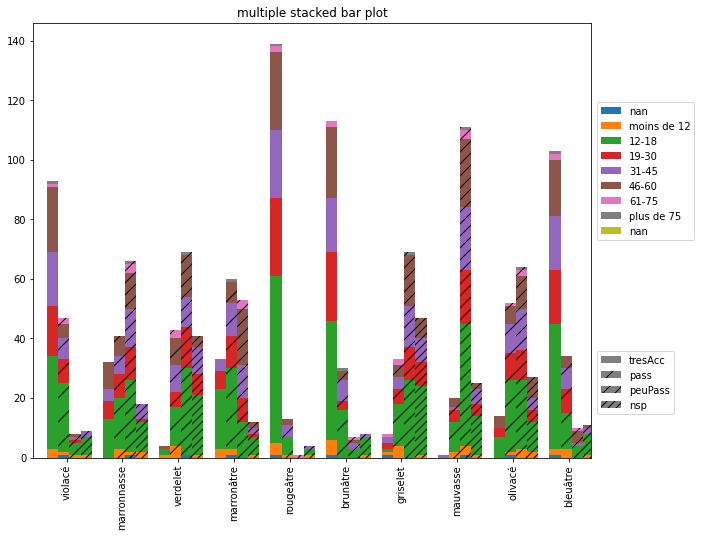

In [87]:
# create fake dataframes
df_tresAcc = pd.DataFrame(frameTresAccept,
                   index=index,
                   columns=columns)

df_pass = pd.DataFrame(framePassable,
                   index=index,
                   columns=columns)

df_peuPass = pd.DataFrame(framePeuAccept,
                   index=index,
                   columns=columns)

df_nsp = pd.DataFrame(frameNsp,
                   index=index,
                   columns=columns)
# Then, just call :
plot_clustered_stacked([df_tresAcc, df_pass, df_peuPass,df_nsp],["tresAcc", "pass", "peuPass","nsp"])